# Analisis

En este notebook analizamos los resultados de los experimentos

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict

In [2]:
def parse_instance(filename: str) -> Dict[str, str]:
    """
    Parsea un nombre de instancia del formato
    
        instancias/control/n_19-i_1.in
    
    Y devuelve un dict con los atributos.
    """
    instance = filename.split('/')[2]
    # -3 por el ''.in'
    pairs = instance[:-3].split('-')
    
    attrs = {}
    for pair in pairs:
        k, v = pair.split('_')
        attrs[k] = v
    
    return attrs

def generate_attrs(df: pd.DataFrame) -> pd.DataFrame:
    """Agrega al dataframe columnas con los atributos de las instancias."""
    # https://stackoverflow.com/questions/23586510/return-multiple-columns-from-pandas-apply
    df = df.copy()
    def attrs(s):
        for k, v in parse_instance(s["instance"]).items():
            s[k] = int(v)
        
        return s

    df = df.apply(attrs, axis=1)
    return df
    
def correlacion_pearson(data_frame, columna1, columna2):
    """Calcula el coeficiente de correlación de pearson."""
    return np.corrcoef(data_frame[columna1], data_frame[columna2])[0,1];

In [3]:
# Leemos los resultados para luego analizar cada dataset/experimento
sns.set_style("whitegrid")
df_results = pd.read_csv("resultados.csv")
df_results = generate_attrs(df_results)

In [4]:
# para poder tener todos como ints, no tenemos que tener NaN, entonces le pongo un valor negativo
# para que lo distingamos. De todas formas nunca deberiamos estar en una situacion donde tengamos
# un NaN porque filtramos por dataset.
df_results = df_results.fillna(-1).astype({'m': 'int64', 'pos': 'int64', 'grupos': 'int64'})
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6498 entries, 0 to 6497
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6498 non-null   int64  
 1   algorithm   6498 non-null   object 
 2   dataset     6498 non-null   object 
 3   grupos      6498 non-null   int64  
 4   i           6498 non-null   int64  
 5   instance    6498 non-null   object 
 6   m           6498 non-null   int64  
 7   n           6498 non-null   int64  
 8   pos         6498 non-null   int64  
 9   time_ms     6498 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 507.8+ KB


In [5]:
# Generamos ahora las paletas de colores para que sean consistentes entre
# todos los graficos
ALGORITHMS = ["FB", "BT", "BT-F", "BT-O-G", "BT-O-C", "DP"]
DATASETS = ["control", "grupos", "low-M", "complejidad-DP", "one-to-rule", "identicos", "cache"]
colorpalette = sns.color_palette("tab10")
PALETTE = {a:c for a,c in zip(ALGORITHMS, colorpalette)}
DATALETTE = {d:c for d, c in zip(DATASETS, colorpalette)}

FIGSIZE = (10,5)

## Complejidades

In [6]:
def comp_plot(df, alg: str):
    g = df.groupby(["dataset", "n"], as_index=False).mean()

    plt.subplots(figsize=FIGSIZE)
    sns.scatterplot(data=g, x="n", y="time_ms", hue="dataset")
    fig = sns.lineplot(data=g, x='n', y='complejidad', color="orange")

    fig.set_title(f"Complejidad de {alg.upper()}")
    plt.savefig(f"img/complejidad/{alg}.svg")

def corr_plot(df, alg: str, group: bool = True):
    plt.figure(figsize=FIGSIZE)
    g = df
    if group:
        g = df.groupby(["dataset", "n"], as_index=False).mean()

    sns.lmplot(data=g, x="time_ms", y="complejidad", height=FIGSIZE[1], aspect=2, line_kws={'color': 'orange'});
    fig = plt.gca()
    fig.set_title(f"Correlacion entre complejidad teórica y tiempo de ejecución\n{alg.upper()}")
    plt.savefig(f"img/complejidad/corr_{alg}.svg")
    # pirson
    print("Índice de correlación de Pearson:", correlacion_pearson(df, "time_ms", "complejidad"));

def cplots(df, alg, group=True):
    comp_plot(df, alg)
    corr_plot(df, alg, group)
    

### Complejidad BT-F

Índice de correlación de Pearson: 0.9682893512096542


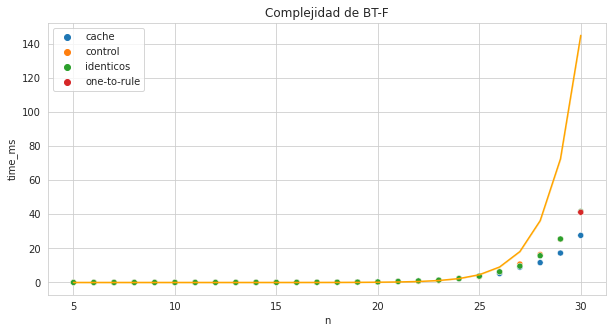

<Figure size 720x360 with 0 Axes>

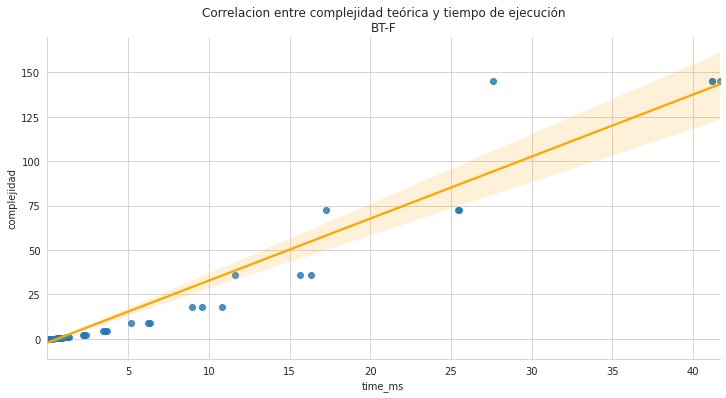

In [7]:
df = df_results[(df_results["algorithm"] == "BT-F") & (df_results["dataset"] != "low-M")].copy()
df["complejidad"] = (2.0 ** df["n"]) * 0.000000135 # Exponencial
cplots(df, "bt-f")

### Complejidad BT-O-C

Índice de correlación de Pearson: 0.9578486072183664


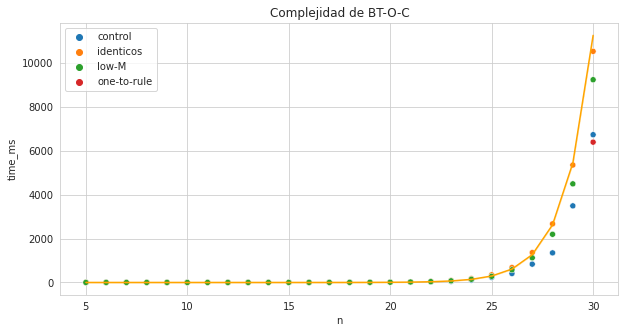

<Figure size 720x360 with 0 Axes>

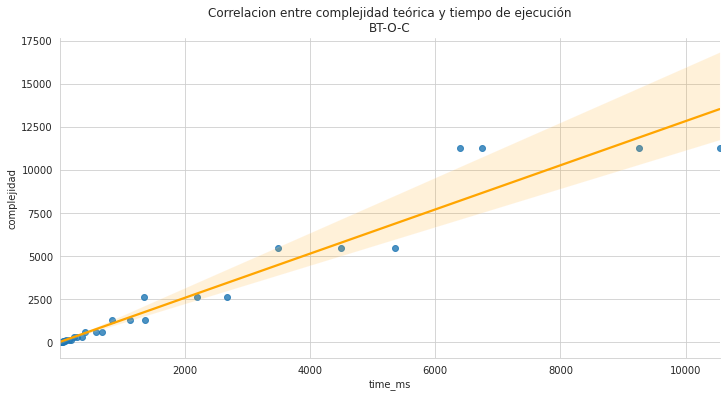

In [8]:
df = df_results[df_results["algorithm"] == "BT-O-C"].copy()
df["complejidad"] = (2.0 ** df["n"]) * df["n"]* 0.00000035 # Exponencial
cplots(df, "bt-o-c")

### Complejidad BT-O-G

Índice de correlación de Pearson: 0.9346087118461958


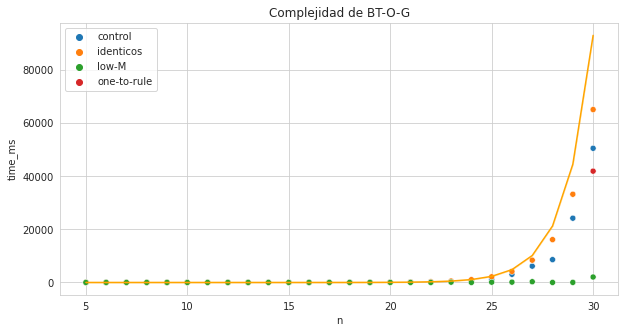

<Figure size 720x360 with 0 Axes>

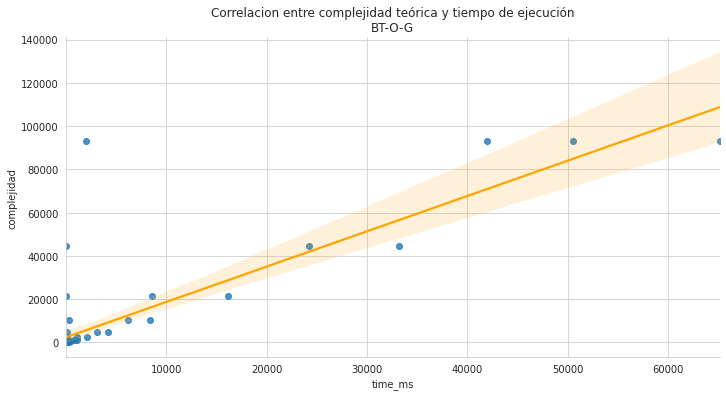

In [9]:
df = df_results[(df_results["algorithm"] == "BT-O-G")].copy() # & (df_results["dataset"] == "identicos")]
df["complejidad"] = (2.0 ** df["n"]) * (np.log(df["n"]) * df["n"]) * 0.00000085 # Exponencial
cplots(df, "bt-o-g")

### Complejidad FB

Índice de correlación de Pearson: 0.9996726574797388


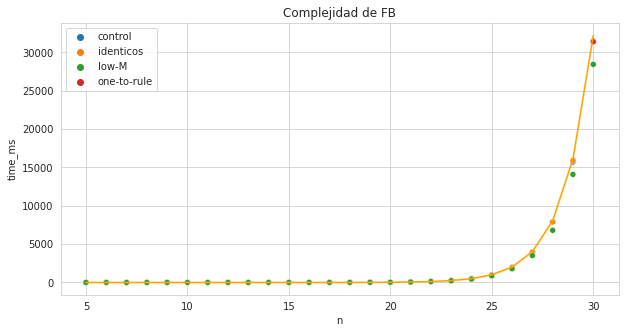

<Figure size 720x360 with 0 Axes>

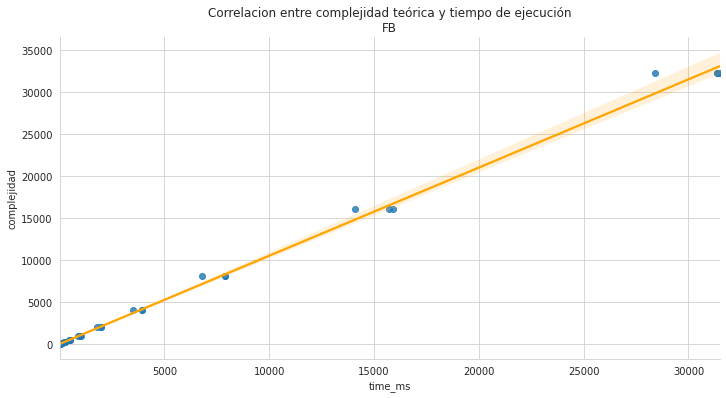

In [10]:
df = df_results[df_results["algorithm"] == "FB"].copy()
df["complejidad"] = (2.0 ** df["n"]) * 0.00003 # Exponencial
cplots(df, "fb")

### Complejidad DP

Índice de correlación de Pearson: 0.9779913462867158


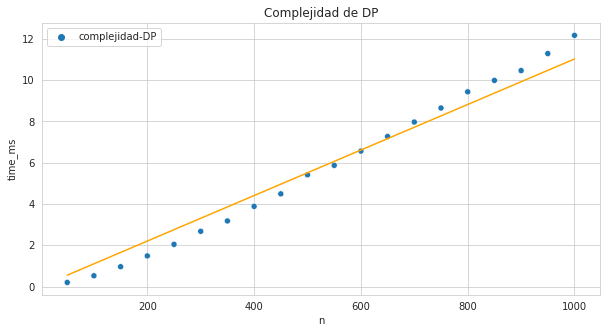

<Figure size 720x360 with 0 Axes>

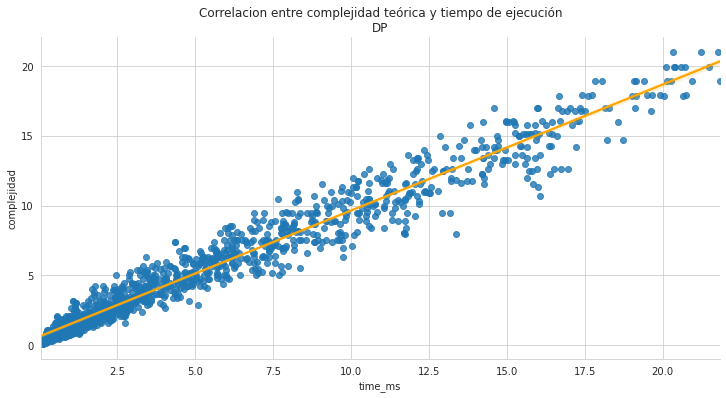

In [11]:
df = df_results[(df_results["dataset"] == "complejidad-DP")].copy()
df["complejidad"] = df["n"] * df["m"] * 0.000021 # Exponencial
cplots(df, "dp", False)

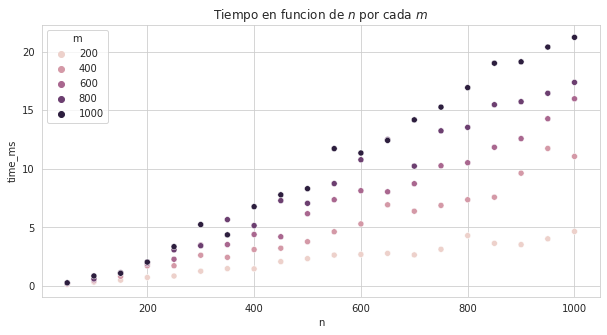

In [12]:
# groby on grails
plt.subplots(figsize=FIGSIZE)
g = df.groupby(["m", "n"], as_index=False).median()
fig = sns.scatterplot(data=g[g["m"].isin([200, 400, 600, 800, 1000])], x="n", y="time_ms", hue="m")
fig.set_title("Tiempo en funcion de $n$ por cada $m$")
plt.savefig("img/complejidad/dp-tiempo-nm.svg")

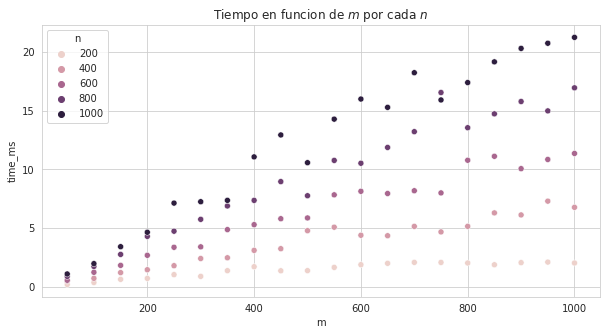

In [13]:
plt.subplots(figsize=FIGSIZE)
fig = sns.scatterplot(data=g[g["n"].isin([200, 400, 600, 800, 1000])], x="m", y="time_ms", hue="n")
fig.set_title("Tiempo en funcion de $m$ por cada $n$")
plt.savefig("img/complejidad/dp-tiempo-mn.svg")

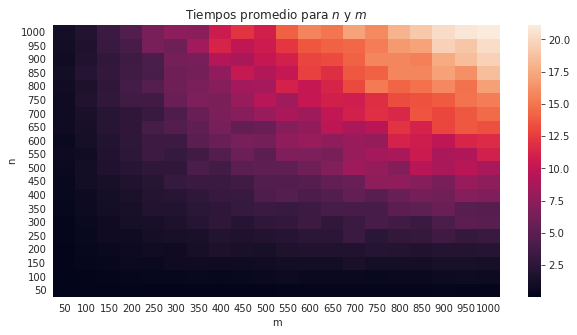

In [14]:
plt.subplots(figsize=FIGSIZE)
df_hm = df.pivot_table(values="time_ms", index=["n"], columns=["m"], aggfunc=np.mean)

ax = sns.heatmap(data=df_hm)
ax.invert_yaxis()
ax.set_title("Tiempos promedio para $n$ y $m$")
plt.savefig("img/complejidad/dp-heatmap.svg")

## Comparativa entre algoritmos

Para dataset de control, casos "reales"

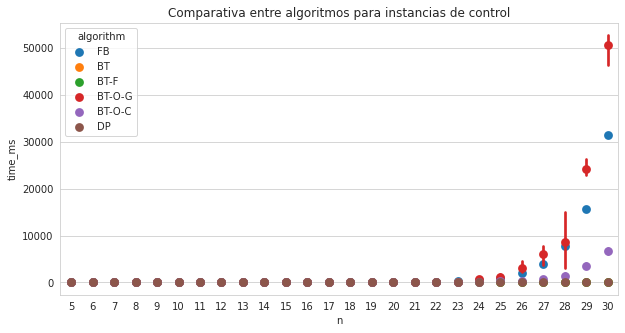

In [15]:
df_control = df_results[(df_results["dataset"] == "control")]
plt.subplots(figsize=FIGSIZE)
g = sns.pointplot(data=df_control, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
g.set_title("Comparativa entre algoritmos para instancias de control")
plt.savefig("img/comparativa/todos.svg");

Haciendo zoom en los más rápidos

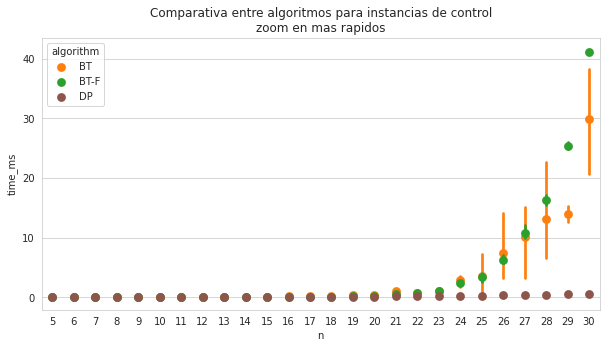

In [16]:
df_control = df_results[(df_results["dataset"] == "control") & (df_results["algorithm"].isin(["BT", "BT-F", "DP"]))]
plt.subplots(figsize=FIGSIZE)
g = sns.pointplot(data=df_control, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
g.set_title("Comparativa entre algoritmos para instancias de control\nzoom en mas rapidos")
plt.savefig("img/comparativa/zoom.svg");

## Performance de las podas

Comparamos las podas entre si y con fuerza bruta a modo de control

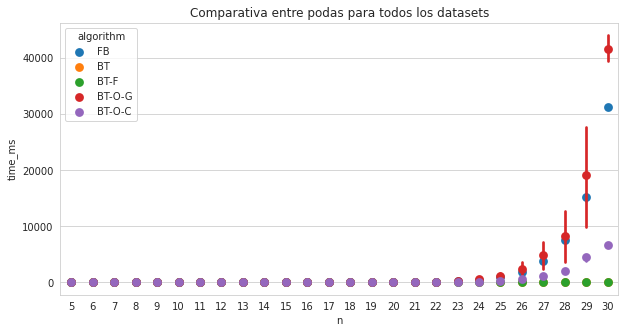

In [17]:
df_podas = df_results[(df_results["algorithm"] != "DP")]
plt.subplots(figsize=FIGSIZE)
g = sns.pointplot(data=df_podas, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
g.set_title("Comparativa entre podas para todos los datasets")
plt.savefig("img/podas/todos.svg");

### Factibilidad - Low M

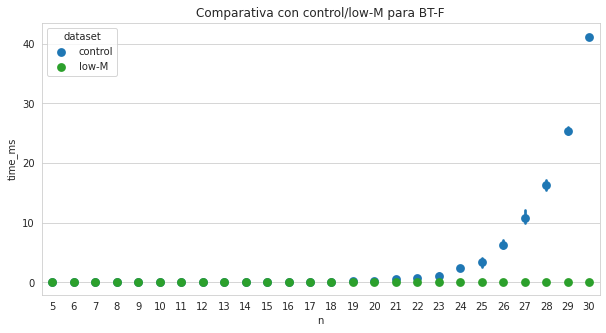

In [18]:
df_low_m = df_results[(df_results["dataset"].isin(["low-M", "control"])) & (df_results["algorithm"] == "BT-F")]
plt.subplots(figsize=FIGSIZE)
g = sns.pointplot(data=df_low_m, x="n", y="time_ms", hue="dataset", join=False, palette=DATALETTE)
g.set_title("Comparativa con control/low-M para BT-F")
plt.savefig("img/podas/factibilidad/low-m-control.svg");

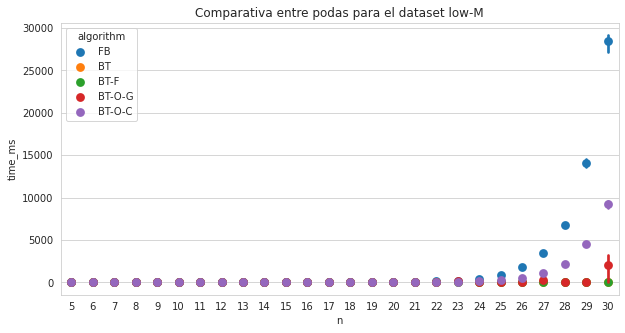

In [19]:
df_low_m = df_podas[df_podas["dataset"] == "low-M"]
plt.subplots(figsize=FIGSIZE)
g = sns.pointplot(data=df_low_m, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
g.set_title("Comparativa entre podas para el dataset low-M")
plt.savefig("img/podas/factibilidad/low-m-comp.svg");

### Optimalidad - One to Rule

### Posición del local especial en optimalidad

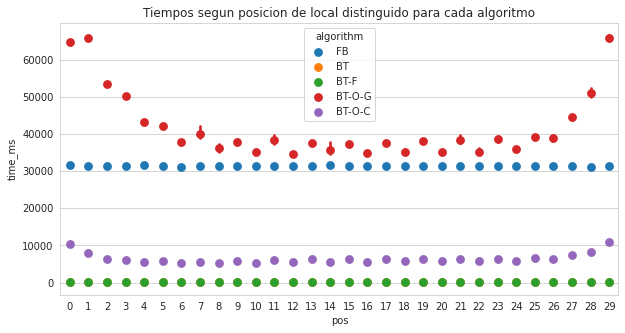

In [20]:
df_posic = df_podas[(df_podas["dataset"] == "one-to-rule") & (df_podas["n"] == 30)] #  & (df_podas["time_ms"] < 50)
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_posic, x="pos", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
fig.set_title("Tiempos segun posicion de local distinguido para cada algoritmo")
plt.savefig("img/podas/optimalidad/one-to-rule-pos.svg");

# bt-f y fb no se ven afectados por la pos

### Optimalidad - Identicos

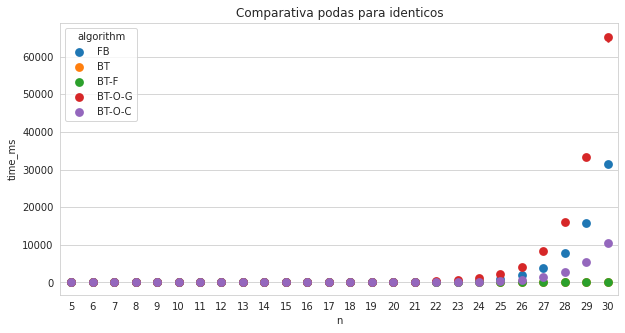

In [21]:
df_id = df_podas[df_podas["dataset"] == "identicos"]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_id, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
fig.set_title("Comparativa podas para identicos")
plt.savefig("img/podas/optimalidad/identicos-comp.svg")

#### Comparativa con control

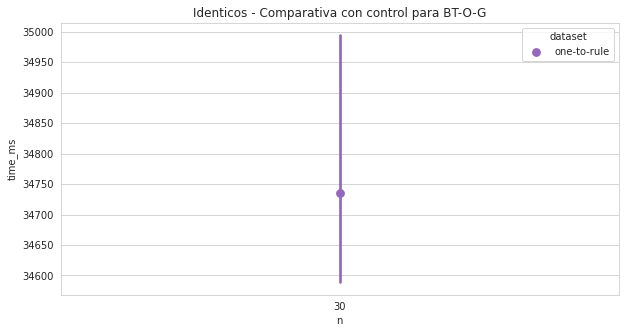

In [22]:
df_btog = df_podas[(df_podas["algorithm"] == "BT-O-G") & (df_podas["dataset"].isin(["control", "identicos", "one-to-rule"]))]
df_btog = df_btog[df_btog["pos"].isin([12, np.nan])]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_btog, x="n", y="time_ms", hue="dataset", join=False, palette=DATALETTE)
fig.set_title("Identicos - Comparativa con control para BT-O-G")
plt.savefig("img/podas/optimalidad/identicos-control_bt-o-g.svg");

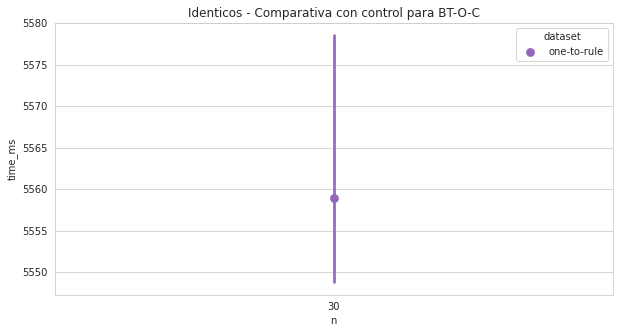

In [23]:
df_btog = df_podas[(df_podas["algorithm"] == "BT-O-C") & (df_podas["dataset"].isin(["control", "identicos", "one-to-rule"]))]
df_btog = df_btog[df_btog["pos"].isin([12, np.nan])]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_btog, x="n", y="time_ms", hue="dataset", join=False, palette=DATALETTE)
fig.set_title("Identicos - Comparativa con control para BT-O-C")
plt.savefig("img/podas/optimalidad/identicos-control_bt-o-c.svg");

## Solapamiento (grupos)

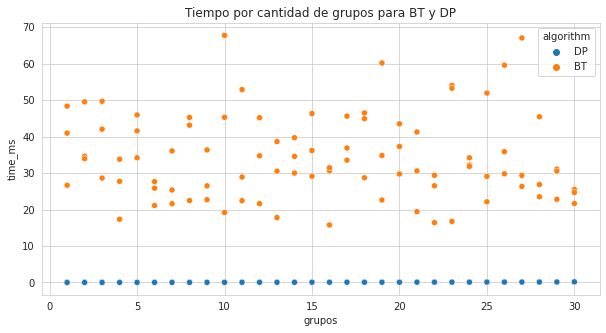

In [24]:
df_grupos = df_results[(df_results["dataset"] == "grupos")]
df_grupos_25 = df_grupos[df_grupos["n"]==30]
plt.subplots(figsize=FIGSIZE)
fig = sns.scatterplot(data=df_grupos_25.sort_values("grupos"), x="grupos", y="time_ms", hue="algorithm")
fig.set_title("Tiempo por cantidad de grupos para BT y DP")
plt.savefig("img/dp/grupos/comp.svg");

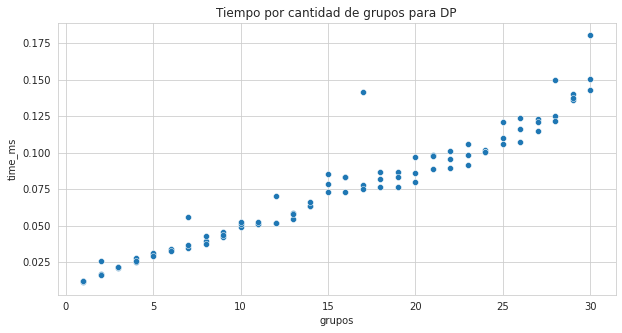

In [25]:
df_grupos = df_results[(df_results["dataset"] == "grupos") & (df_results["algorithm"] == "DP")]
df_grupos_25 = df_grupos[df_grupos["n"]==30]
plt.subplots(figsize=FIGSIZE)
fig = sns.scatterplot(data=df_grupos_25.sort_values("grupos"), x="grupos", y="time_ms")
fig.set_title("Tiempo por cantidad de grupos para DP")
plt.savefig("img/dp/grupos/comp.svg");

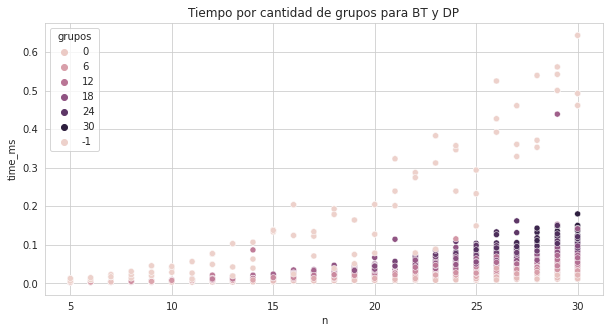

In [26]:
df_grupos = df_results[(df_results["dataset"].isin(["grupos", "control"])) & (df_results["algorithm"]=="DP")]
#df_grupos_25 = df_grupos[df_grupos["n"]==25]
plt.subplots(figsize=FIGSIZE)
fig = sns.scatterplot(data=df_grupos, x="n", y="time_ms", hue="grupos")
sns.scatterplot(data=df_grupos[df_grupos["dataset"] == "control"], x="n", y="time_ms", hue="grupos")
fig.set_title("Tiempo por cantidad de grupos para BT y DP")
plt.savefig("img/dp/grupos/comp.svg");

## Caché

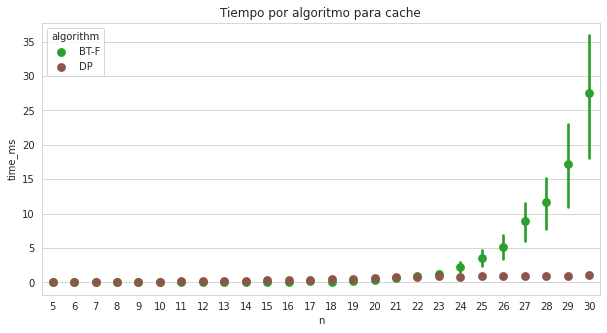

In [27]:
df_cache = df_results[(df_results["dataset"] == "cache")]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_cache, x="n", y="time_ms", hue="algorithm", join=False, palette=PALETTE)
fig.set_title("Tiempo por algoritmo para cache")
plt.savefig("img/dp/cache/comp.svg");

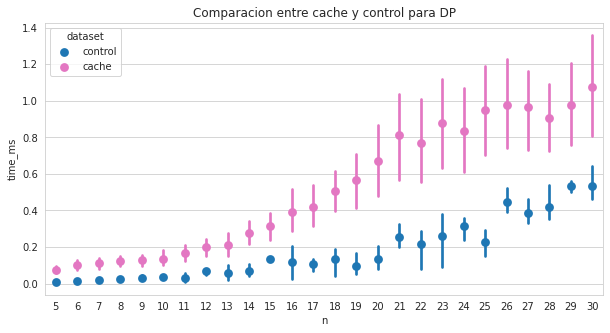

In [28]:
df_cache = df_results[(df_results["dataset"].isin(["control", "cache"])) & (df_results["algorithm"] == "DP")]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_cache, x="n", y="time_ms", hue="dataset", palette=DATALETTE, join=False)
fig.set_title("Comparacion entre cache y control para DP")
plt.savefig("img/dp/cache/control.svg");

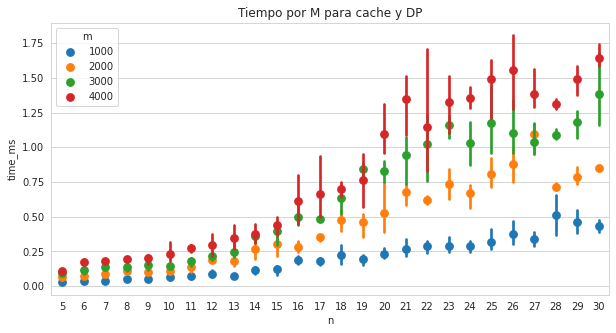

In [29]:
df_cache = df_results[(df_results["dataset"] == "cache") & (df_results["algorithm"] == "DP")]
plt.subplots(figsize=FIGSIZE)
fig = sns.pointplot(data=df_cache, x="n", y="time_ms", hue="m", join=False)
fig.set_title("Tiempo por M para cache y DP")
plt.savefig("img/dp/cache/por-m.svg");

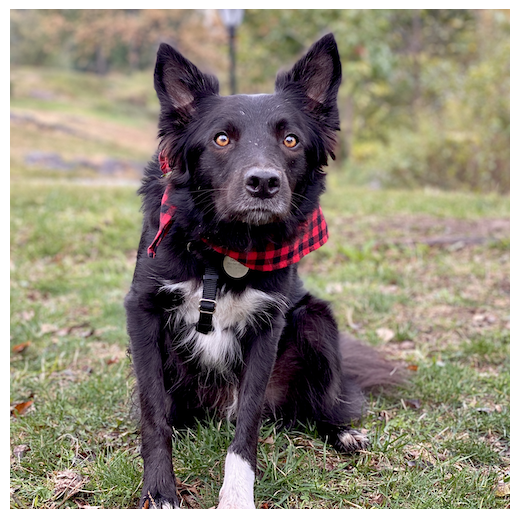

In [30]:
## Plot mas importante, recordar ponerlo en el informe.
sns.dogplot()